In [2]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops

# Do all these plots with centroid based coloring

# rawfpath = "../data/spherical/spherical-3d.out"
# rawfpath = "../data/spherical/spherical-4d.out"
# rawfpath = "../data/spherical/spherical-8d.out"

# rawfpath = "../data/knee/knee-3d.out"
# rawfpath = "../data/knee/knee-4d.out"
# rawfpath = "../data/knee/knee-8d.out"

# rawfpath = "../data/line-surface/line-3d.out"
rawfpath = "../data/line-surface/line-4d.out"
# rawfpath = "../data/line-surface/line-6d.out"
# rawfpath = "../data/line-surface/line-8d.out"

# rawfpath = "../data/carcrash/carcrash-3d.out"
# rawfpath = "../data/carcrash/carcrash-c1/carcrash-c1-3d.out"
# rawfpath = "../data/carcrash/carcrash-c2/carcrash-c2-3d.out"

# Do all these plots with constraint based coloring

# rawfpath = "../data/knee-const/knee-const-3d.out"
# rawfpath = "../data/knee-const/knee-const-4d.out"
# rawfpath = "../data/knee-const/knee-const-8d.out"

# rawfpath = "../data/knee-const-mod/knee-const-mod-3d.out"
# rawfpath = "../data/knee-const-mod/knee-const-mod-4d.out"

# rawfpath = "../data/isolated/isolated-3d.out"
# rawfpath = "../data/isolated/isolated-4d.out"
# rawfpath = "../data/isolated/isolated-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-4d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-5d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d.out"

# rawfpath = "../data/gaa-das/gaa-das-10d.out"
# rawfpath = "../data/gaa-lhs/gaa-lhs-10d.out"

# some ML data sets
# rawfpath = "../data/airofoil/airofoil-5d.out"
# rawfpath = "../data/banknote/banknote-4d.out"
# rawfpath = "../data/blood/blood-4d.out"
# rawfpath = "../data/cccp/cccp-4d.out"
# rawfpath = "../data/concrete/concrete-8d.out"
# rawfpath = "../data/iris/iris-4d.out"
# rawfpath = "../data/mammogram/mammogram-5d.out"
# rawfpath = "../data/wil/wil-7d.out"
# rawfpath = "../data/yeast/yeast-8d.out"

# do visualization based on distance from the centroid?
docentroid = False

# get the path and filename from the rawfpath
path, rawfile = os.path.split(rawfpath)
# get the prefix
prefix = rawfile.split('.')[0]

# load the normalized points
points = fmt.load(os.path.join(path, prefix + "-norm.out"))

# load the CV values
cvfpath = os.path.join(path, prefix + "-cv.out")
if not docentroid and os.path.exists(cvfpath):
    cv = [v[0] if len(v) == 1 else v for v in fmt.load(cvfpath)]
    [low, up] = vops.get_bound(cv)
    cv = vops.normalize(cv, low, up)
    color = dcor.recolor_by_cv(cv)
else:
    color = dcor.recolor_by_centroid(points)

# load the normalized trade-off values
mufpath = os.path.join(path, prefix + "-norm-mu.out")
knee_idx = None
if os.path.exists(mufpath):
    mu = [v[0] if len(v) == 1 else v for v in fmt.load(mufpath)]
    # resize the points w.r.t. trade-offs
    size = dcor.rescale_by_tradeoff(mu)
    (color, knee_idx) = dcor.recolor_by_tradeoff(size, color)

# load the class labels
classfpath = os.path.join(path, prefix + "-class.out")
if os.path.exists(classfpath):
    labels = [v[0] if len(v) == 1 else v for v in \
            fmt.load(classfpath, dtype = dcor.dtypes[prefix])]
    color = dcor.recolor_by_labels(labels, dtype = dcor.dtypes[prefix])
    size = [5.0 for _ in range(len(points))]

# alpha values
alpha = [0.2, 0.8] # alpha for plots with knee
# alpha = [1.0, 1.0] # alpha for general case

<IPython.core.display.Javascript object>


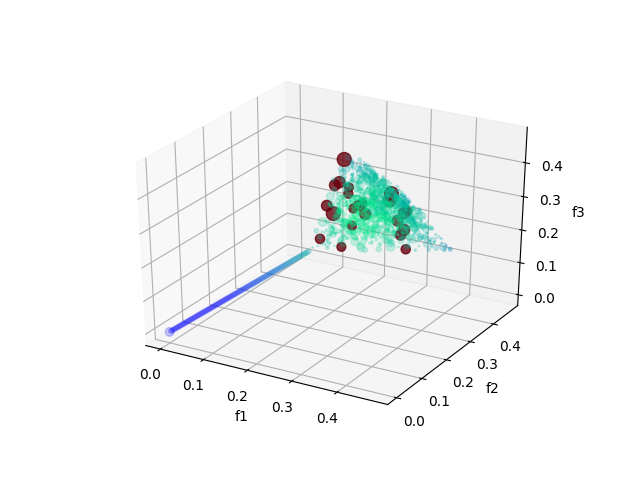

In [3]:
# use the original obj values for scatter plot.
rawpoints = fmt.load(rawfpath)
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()

In [15]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
pca.fit(np.array(rawpoints))
pca_score = pca.explained_variance_ratio_
v = pca.components_[0].tolist()
print(pca_score)
print(v)

[0.86274259]
[-0.30483698430847894, -0.3122556832602037, -0.3112249758606469, 0.844221425734952]


In [20]:
import math

ndist = []
for p in rawpoints:
    b = vops.dot(p, v)
    a = vops.distlp([0,0,0,0], p)
    ndist.append(math.sqrt(a * a - b * b))
print(ndist)

[0.5359945749072886, 0.534630923960851, 0.5332672755510063, 0.5319036296972633, 0.5305399864193326, 0.5291763457371268, 0.5278127076707643, 0.5264490722405727, 0.5250854394670899, 0.523721809371068, 0.522358181973476, 0.5209945572955026, 0.5196309353585573, 0.5182673161842766, 0.5169036997945243, 0.5155400862113965, 0.5141764754572223, 0.5128128675545698, 0.511449262526246, 0.5100856603953031, 0.5087220611850398, 0.5073584649190053, 0.5059948716210025, 0.504631281315092, 0.5032676940255947, 0.5019041097770958, 0.5005405285944481, 0.49917695050277655, 0.4978133755274809, 0.49644980369423963, 0.4950862350290149, 0.4937226695580545, 0.49235910730789817, 0.49099554830537934, 0.4896319925776306, 0.4882684401520882, 0.48690489105649454, 0.48554134531890436, 0.4841778029676885, 0.48281426403153754, 0.48145072853946735, 0.4800871965208237, 0.4787236680052861, 0.47736014302287316, 0.4759966216039478, 0.47463310377922135, 0.4732695895797591, 0.4719060790369853, 0.4705425721826884, 0.469179069049

<IPython.core.display.Javascript object>


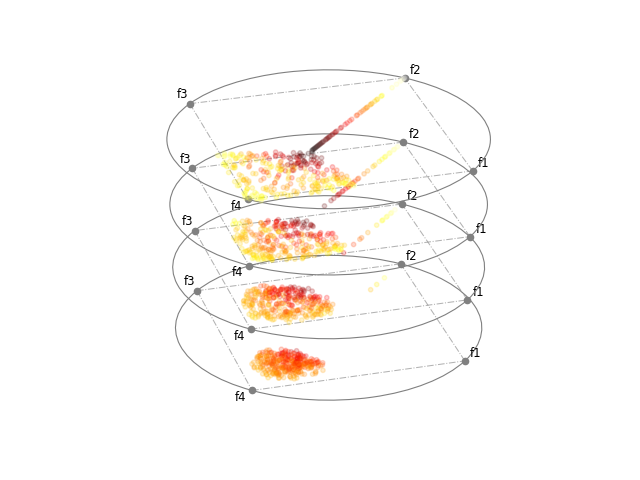

In [24]:
import matplotlib as mpl
import matplotlib.cm as cm

[lb, ub] = vops.get_bound(ndist)
nndist = vops.normalize(ndist, lb, ub)

color = []
for d in nndist:
    color.append(cm.hot(d))

palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = 10.0, c = color, alpha = [0.2, 0.2], camera = dcor.cam_palette[prefix], \
            knee_idx = None, mode = "sc")
# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-invsc-ndist.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()

<IPython.core.display.Javascript object>


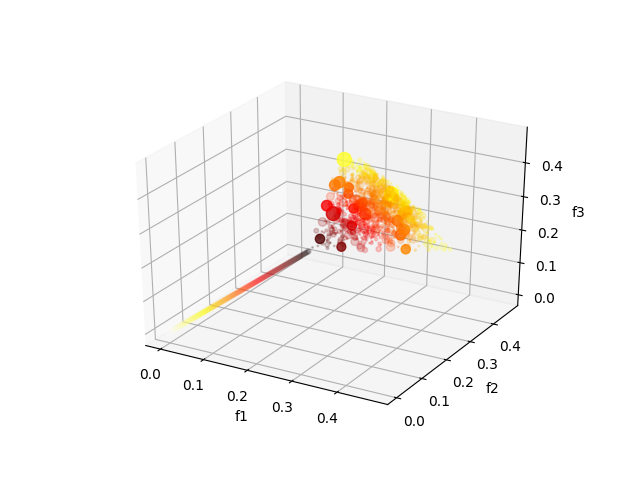

In [25]:
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-ndist.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()